In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pyp
from skimage import io, data

def resize_image(image, padding):
    """
    This function lets you resize an image for working with some operations that require
    adding (or extend) the borders of the input image, specially for Convolution and
    Binarization methods like Niblack's and Sauvola's.
    Returns the image resized.
    """
    image_height, image_width = image.shape
    new_image_height, new_image_width = 2 * padding + image_height, 2 * padding + image_width
    new_image = np.zeros((new_image_height, new_image_width))
    
    # Copy the original image at the center of the new extended image.
    new_image[padding:new_image_height - padding, padding:new_image_width - padding] = image
    
    # Get all borders
    image_left_border = np.array([image[:,0]]).T
    image_right_border = np.array([image[:,-1]]).T
    image_top_border = image[0,:]
    image_bottom_border = image[-1,:]
    
    # Get all corners
    # LT : Left-Top    | RT : Right-Top
    # LB : Left-Bottom | RB : Right-Bottom
    image_lt_corner = np.array([image[0,0]])
    image_rt_corner = np.array([image[0,-1]])
    image_lb_corner = np.array([image[-1,0]])
    image_rb_corner = np.array([image[-1,-1]])
    
    # Copy the left border
    new_image[padding:image_height + padding,
              0:padding] = np.tile(image_left_border, (1, padding))
    
    # Copy the right border
    new_image[padding:image_height + padding,
              image_width + padding:new_image_width] = np.tile(image_right_border, (1, padding))
    
    # Copy the top border
    new_image[0:padding,
              padding:image_width + padding] = np.tile(image_top_border, (padding, 1))

    # Copy the bottom border
    new_image[image_height + padding:new_image_height,
              padding:image_width + padding] = np.tile(image_bottom_border, (padding, 1))
    
    # Copy the corners
    new_image[0:padding, 0:padding] = np.tile(image_lt_corner, (padding, padding))
    new_image[0:padding, image_width + padding:new_image_width] = np.tile(image_rt_corner, (padding, padding))
    new_image[image_height + padding:new_image_height, 0:padding] = np.tile(image_lb_corner, (padding, padding))
    new_image[image_height + padding:new_image_height, image_width + padding:new_image_width] = np.tile(image_rb_corner, (padding, padding))
    
    return new_image

def diffusion_coefficient(gradient_value, K, option = 1):
    if option == 1: return np.exp(-(np.abs(gradient_value)/K)**2)
    elif option == 2: return 1 / (1 + (np.abs(gradient_value)/K)**2)
    else: return None
    
def anisotropic_diffusion(image, steps = 100, K = 1, _lambda = 0.25, diff_coef = 1):
    new_image = np.copy(image)
    for t in np.arange(steps):
        extended_image = resize_image(new_image, padding=1)
        difference_north = extended_image[:-2, 1:-1] - extended_image[1:-1, 1:-1]
        difference_south = extended_image[2:, 1:-1]  - extended_image[1:-1, 1:-1] 
        difference_east  = extended_image[1:-1, 2:]  - extended_image[1:-1, 1:-1] 
        difference_west  = extended_image[1:-1, :-2] - extended_image[1:-1, 1:-1]
        new_image = new_image + _lambda * \
                    (diffusion_coefficient(difference_north, K, diff_coef) * difference_north + \
                     diffusion_coefficient(difference_south, K, diff_coef) * difference_south + \
                     diffusion_coefficient(difference_east, K, diff_coef) * difference_east + \
                     diffusion_coefficient(difference_west, K, diff_coef) * difference_west)
    return new_image

def load_images(folder_name):
    image_set = []
    for i in np.arange(10):
        image_path = "{}/{}.png".format(folder_name, i)
        image_set.append(io.imread(image_path))
    return image_set

def perform_anisotropic_diffusion(image_set, steps_list, K_list, lambda_list):
    print(">> Anisotropic Diffusion evaluation has started!")
    varying_steps_result_set = []
    varying_K_result_set = []
    varying_lambda_result_set = []
    for image in image_set:
        # First, we perform Anisotropic Diffusion varying the steps.
        # Constant values are: K = 1 and lambda = 0.25
        for steps in steps_list:
            first_result  = anisotropic_diffusion(image, steps = steps, K = 1, _lambda = 0.25, diff_coef = 1)
            second_result = anisotropic_diffusion(image, steps = steps, K = 1, _lambda = 0.25, diff_coef = 2)
            varying_steps_result_set.append([first_result, second_result])
            
        # Second, we perform Anisotropic Diffusion varying the K-value.
        # Constant values are: steps = 100 and lambda = 0.25
        for K in K_list:
            first_result  = anisotropic_diffusion(image, steps = 100, K = K, _lambda = 0.25, diff_coef = 1)
            second_result = anisotropic_diffusion(image, steps = 100, K = K, _lambda = 0.25, diff_coef = 2)
            varying_K_result_set.append([first_result, second_result])
        
        # Third, we perform Anisotropic Diffusion varying the lambda.
        # Constant values are: steps = 100 and K = 1
        for _lambda in lambda_list:
            first_result  = anisotropic_diffusion(image, steps = 100, K = 1, _lambda = _lambda, diff_coef = 1)
            second_result = anisotropic_diffusion(image, steps = 100, K = 1, _lambda = _lambda, diff_coef = 2)
            varying_lambda_result_set.append([first_result, second_result])
    print(">> Job done!")
    return varying_steps_result_set, varying_K_result_set, varying_lambda_result_set


image_set = load_images("impnoise_005")
steps_list = [50, 100, 200]
K_list = [0.5, 1, 2]
lambda_list = [0.25, 0.5, 1]

a, b, c = perform_anisotropic_diffusion(image_set, steps_list, K_list, lambda_list)

>> Anisotropic Diffusion evaluation has started!
>> Job done!


C:\ProgramData\Anaconda3\envs\image_processing\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


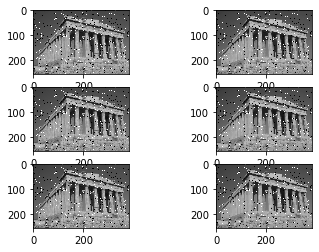

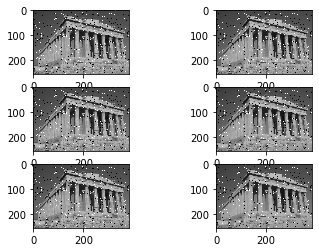

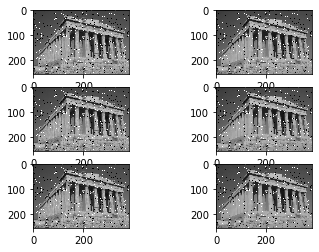

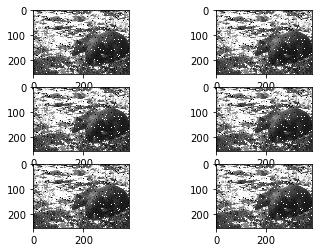

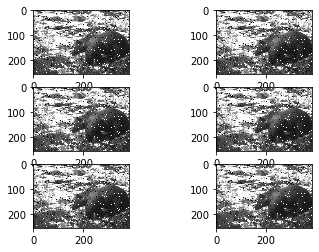

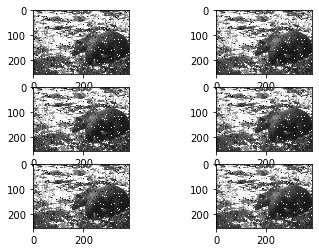

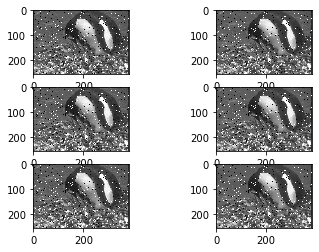

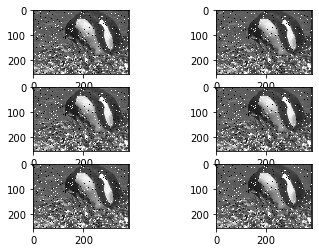

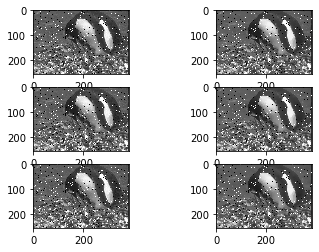

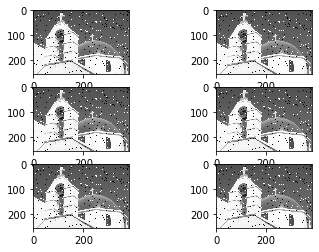

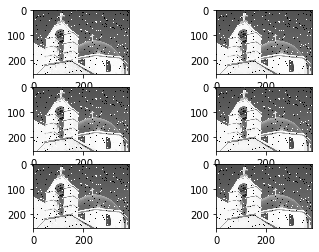

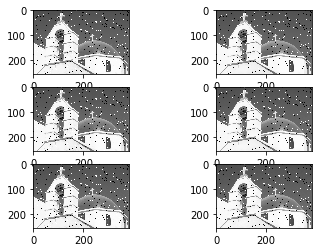

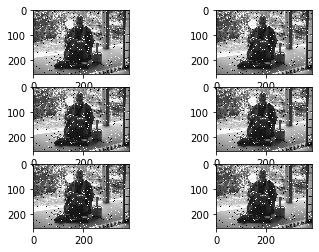

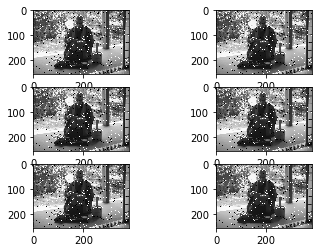

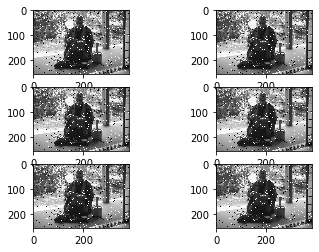

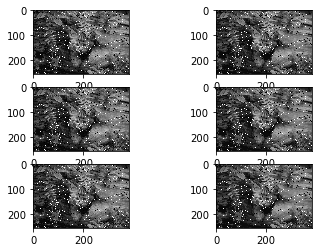

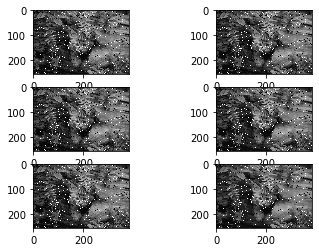

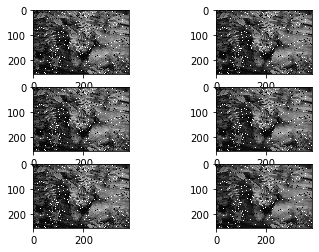

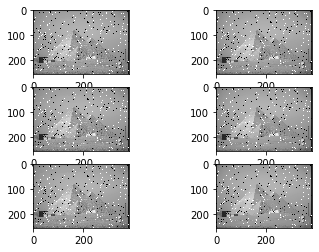

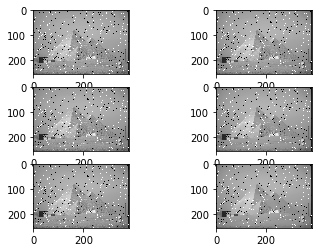

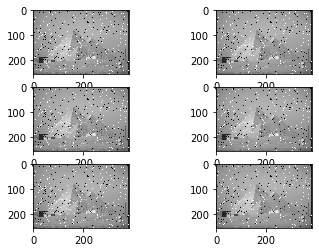

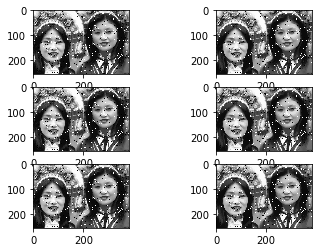

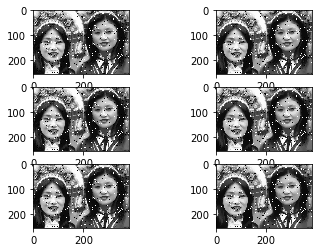

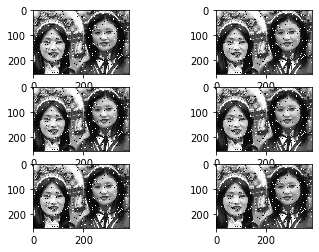

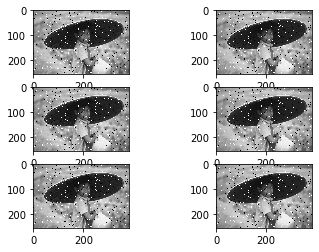

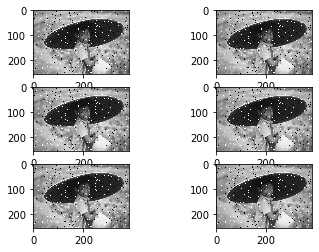

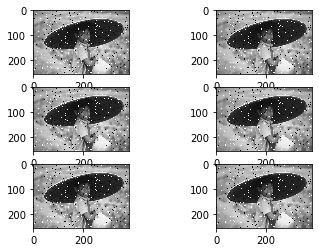

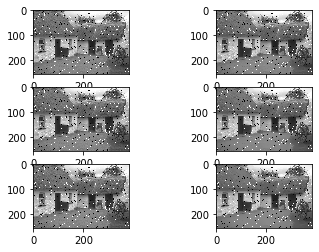

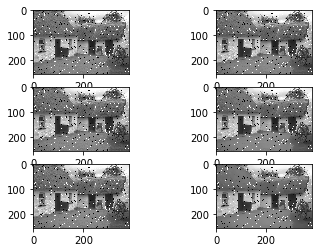

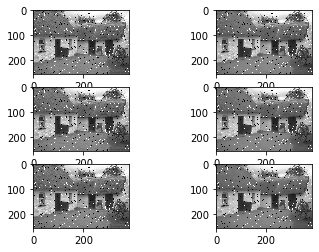

In [16]:
i = 0
total = len(a)
while i < total:
    fig = plt.figure()
    ax11 = fig.add_subplot(3,2,1)
    ax12 = fig.add_subplot(3,2,2)
    
    ax21 = fig.add_subplot(3,2,3)
    ax22 = fig.add_subplot(3,2,4)
    
    ax31 = fig.add_subplot(3,2,5)
    ax32 = fig.add_subplot(3,2,6)
    
    ax11.imshow(a[i][0], cmap='gray')
    ax12.imshow(a[i][1], cmap='gray')
    
    ax21.imshow(a[i+1][0], cmap='gray')
    ax22.imshow(a[i+1][1], cmap='gray')
    
    ax31.imshow(a[i+2][0], cmap='gray')
    ax32.imshow(a[i+2][1], cmap='gray')
    
    i += 3